In [79]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%config InlineBackend.figure_format = 'retina'

In [80]:
dtrain = pd.read_csv('data/train.csv')
dtest = pd.read_csv('data/test.csv').iloc[:, 1:-1]

## Asiding the response variable

In [82]:
response = dtrain.Purchase
dtrain.drop(['Purchase'], inplace=True, axis=1)

In [83]:
dtrain.shape

(550068, 11)

In [84]:
dtest.shape

(233599, 11)

In [85]:
data = dtrain.append(dtest)

## Cleaning the data

### Feature Creation

#### 1. Age

In [86]:
def split_age(age, which):
    if which == 'lower':
        if age[2] != '+':
            return int(age.split('-')[0])
        else:
            return int(age.split('+')[0])
    elif which == 'upper':
        if age[2] != '+':
            return int(age.split('-')[1])
        else:
            return 80 # Because average maximum age is 80

In [87]:
data['lower_age'] = data.Age.apply(lambda row: split_age(row, 'lower'))
data['upper_age'] = data.Age.apply(lambda row: split_age(row, 'upper'))
data['mean_age'] = (data.lower_age + data.upper_age) / 2.0

In [88]:
data.drop(['Age', 'lower_age', 'upper_age'], inplace=True, axis=1)

In [89]:
data.head()

User_ID Product_ID Gender  Occupation City_Category  \
0  1000001  P00069042      F          10             A   
1  1000001  P00248942      F          10             A   
2  1000001  P00087842      F          10             A   
3  1000001  P00085442      F          10             A   
4  1000002  P00285442      M          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  mean_age  
0                 NaN                 NaN       8.5  
1                 6.0                14.0       8.5  
2                 NaN                 NaN       8.5  
3                14.0                 NaN       8.5  
4                 NaN                 NaN      67.5

#### 2. Stay_In_Current_City_Years

In [90]:
data.Stay_In_Current_City_Years.unique()

array(['2', '4+', '3', '1', '0'], dtype=object)

In [91]:
data.loc[data.Stay_In_Current_City_Years == '4+', 'Stay_In_Current_City_Years'] = '4'
data['Stay_In_Current_City_Years'] = data.Stay_In_Current_City_Years.astype(int)

## Filling the NAs

In [92]:
data.head()

User_ID Product_ID Gender  Occupation City_Category  \
0  1000001  P00069042      F          10             A   
1  1000001  P00248942      F          10             A   
2  1000001  P00087842      F          10             A   
3  1000001  P00085442      F          10             A   
4  1000002  P00285442      M          16             C   

   Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                           2               0                   3   
1                           2               0                   1   
2                           2               0                  12   
3                           2               0                  12   
4                           4               0                   8   

   Product_Category_2  Product_Category_3  mean_age  
0                 NaN                 NaN       8.5  
1                 6.0                14.0       8.5  
2                 NaN                 NaN       8.5  
3                14.0                 NaN       8.5  
4                 NaN                 NaN      67.5

In [93]:
data.fillna(-999, inplace=True)

In [94]:
data.head()

User_ID Product_ID Gender  Occupation City_Category  \
0  1000001  P00069042      F          10             A   
1  1000001  P00248942      F          10             A   
2  1000001  P00087842      F          10             A   
3  1000001  P00085442      F          10             A   
4  1000002  P00285442      M          16             C   

   Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                           2               0                   3   
1                           2               0                   1   
2                           2               0                  12   
3                           2               0                  12   
4                           4               0                   8   

   Product_Category_2  Product_Category_3  mean_age  
0              -999.0              -999.0       8.5  
1                 6.0                14.0       8.5  
2              -999.0              -999.0       8.5  
3                14.0              -999.0       8.5  
4              -999.0              -999.0      67.5

In [95]:
data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years      int64
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
mean_age                      float64
dtype: object

In [96]:
from sklearn.preprocessing import LabelEncoder

In [97]:
le = LabelEncoder()
data['City_Category'] = le.fit_transform(data.City_Category)
data['Gender'] = le.fit_transform(data.Gender)
data['User_ID'] = le.fit_transform(data.User_ID)
data['Product_ID'] = le.fit_transform(data.Product_ID)

In [98]:
cleaned_train = data.iloc[0:550068, :]
cleaned_test = data.iloc[550068:, :]

In [100]:
cleaned_train.is_copy = False
cleaned_test.is_copy = False
cleaned_train.loc[:, 'Purchase'] = response
cleaned_test.loc[:, 'Purchase'] = -1

In [110]:
cleaned_test.to_csv('data/cleaned_test.csv', index=False)
cleaned_train.to_csv('data/cleaned_train.csv', index=False)
data = cleaned_train.append(cleaned_test)
data.to_csv('data/cleaned_data.csv', index=False)

## Variable Importance

In [111]:
import xgboost as xgb
from pprint import pprint
import operator

In [112]:
def xgb_feature_importance(features, labels, num_rounds, fnames="*"):
    if fnames == "*":
        pass
    else:
        # // TODO Implement feature selection later
        pass
    
    param = {}
    param['objective'] = 'reg:linear'
    param['eta'] = 0.01
    param['max_depth'] = 8
    param['seed'] = 42
    param['nthread'] = -1
    param['eval_metric'] = "rmse"
    param['silent'] = 1
    dtrain = xgb.DMatrix(features, label=labels)
    watchlist = [(dtrain, 'train')]
    gbdt = xgb.train(param, dtrain, num_rounds, watchlist)
    importance = gbdt.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()
    plt.figure()
    df.plot()
    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.show()

[0]	train-rmse:10440.1
[1]	train-rmse:10343.6
[2]	train-rmse:10248.2
[3]	train-rmse:10153.7
[4]	train-rmse:10060.3
[5]	train-rmse:9967.92
[6]	train-rmse:9876.54
[7]	train-rmse:9786.16
[8]	train-rmse:9696.72
[9]	train-rmse:9608.28
[10]	train-rmse:9520.81
[11]	train-rmse:9434.28
[12]	train-rmse:9348.71
[13]	train-rmse:9264.07
[14]	train-rmse:9180.37
[15]	train-rmse:9097.54
[16]	train-rmse:9015.65
[17]	train-rmse:8934.65
[18]	train-rmse:8854.54
[19]	train-rmse:8775.34
[20]	train-rmse:8696.89
[21]	train-rmse:8619.36
[22]	train-rmse:8542.69
[23]	train-rmse:8466.83
[24]	train-rmse:8391.88
[25]	train-rmse:8317.7
[26]	train-rmse:8244.37
[27]	train-rmse:8171.87
[28]	train-rmse:8100.19
[29]	train-rmse:8029.29
[30]	train-rmse:7959.21
[31]	train-rmse:7889.89
[32]	train-rmse:7821.37
[33]	train-rmse:7753.64
[34]	train-rmse:7686.68
[35]	train-rmse:7620.45
[36]	train-rmse:7554.97
[37]	train-rmse:7490.23
[38]	train-rmse:7426.25
[39]	train-rmse:7363
[40]	train-rmse:7300.46
[41]	train-rmse:7238.62
[42]	t

[334]	train-rmse:2764.8
[335]	train-rmse:2764.09
[336]	train-rmse:2763.27
[337]	train-rmse:2762.55
[338]	train-rmse:2761.72
[339]	train-rmse:2760.86
[340]	train-rmse:2760.17
[341]	train-rmse:2759.39
[342]	train-rmse:2758.52
[343]	train-rmse:2757.83
[344]	train-rmse:2757.06
[345]	train-rmse:2756.44
[346]	train-rmse:2755.81
[347]	train-rmse:2755.02
[348]	train-rmse:2754.25
[349]	train-rmse:2753.64
[350]	train-rmse:2752.97
[351]	train-rmse:2752.33
[352]	train-rmse:2751.57
[353]	train-rmse:2750.99
[354]	train-rmse:2750.27
[355]	train-rmse:2749.53
[356]	train-rmse:2748.98
[357]	train-rmse:2748.41
[358]	train-rmse:2747.74
[359]	train-rmse:2747.05
[360]	train-rmse:2746.53
[361]	train-rmse:2745.79
[362]	train-rmse:2745.24
[363]	train-rmse:2744.71
[364]	train-rmse:2744.04
[365]	train-rmse:2743.39
[366]	train-rmse:2742.88
[367]	train-rmse:2742.21
[368]	train-rmse:2741.68
[369]	train-rmse:2741.18
[370]	train-rmse:2740.66
[371]	train-rmse:2740.16
[372]	train-rmse:2739.64
[373]	train-rmse:2738.93
[

[664]	train-rmse:2649.31
[665]	train-rmse:2649.21
[666]	train-rmse:2649.08
[667]	train-rmse:2648.81
[668]	train-rmse:2648.67
[669]	train-rmse:2648.43
[670]	train-rmse:2648.36
[671]	train-rmse:2648.09
[672]	train-rmse:2647.98
[673]	train-rmse:2647.82
[674]	train-rmse:2647.68
[675]	train-rmse:2647.55
[676]	train-rmse:2647.43
[677]	train-rmse:2647.31
[678]	train-rmse:2647.05
[679]	train-rmse:2646.88
[680]	train-rmse:2646.63
[681]	train-rmse:2646.53
[682]	train-rmse:2646.35
[683]	train-rmse:2646.21
[684]	train-rmse:2645.98
[685]	train-rmse:2645.77
[686]	train-rmse:2645.65
[687]	train-rmse:2645.56
[688]	train-rmse:2645.39
[689]	train-rmse:2645.26
[690]	train-rmse:2645.01
[691]	train-rmse:2644.79
[692]	train-rmse:2644.72
[693]	train-rmse:2644.52
[694]	train-rmse:2644.41
[695]	train-rmse:2644.17
[696]	train-rmse:2644.08
[697]	train-rmse:2643.85
[698]	train-rmse:2643.63
[699]	train-rmse:2643.5
[700]	train-rmse:2643.37
[701]	train-rmse:2643.22
[702]	train-rmse:2643.15
[703]	train-rmse:2642.93
[

[994]	train-rmse:2601.28
[995]	train-rmse:2601.12
[996]	train-rmse:2601.02
[997]	train-rmse:2600.82
[998]	train-rmse:2600.67
[999]	train-rmse:2600.57


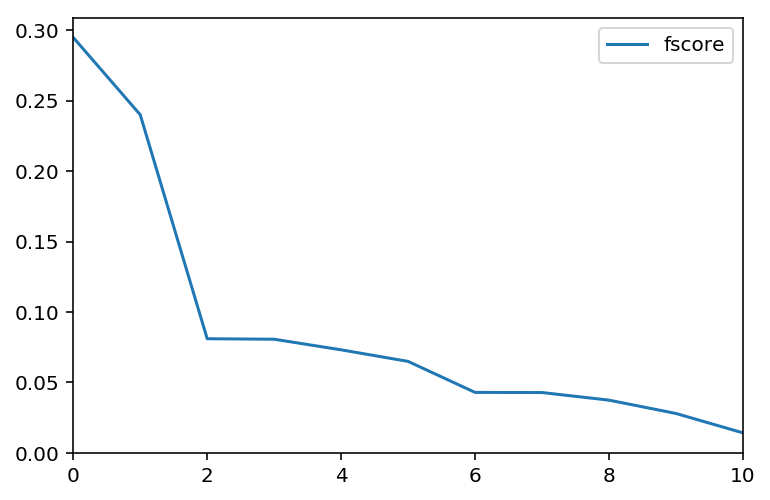

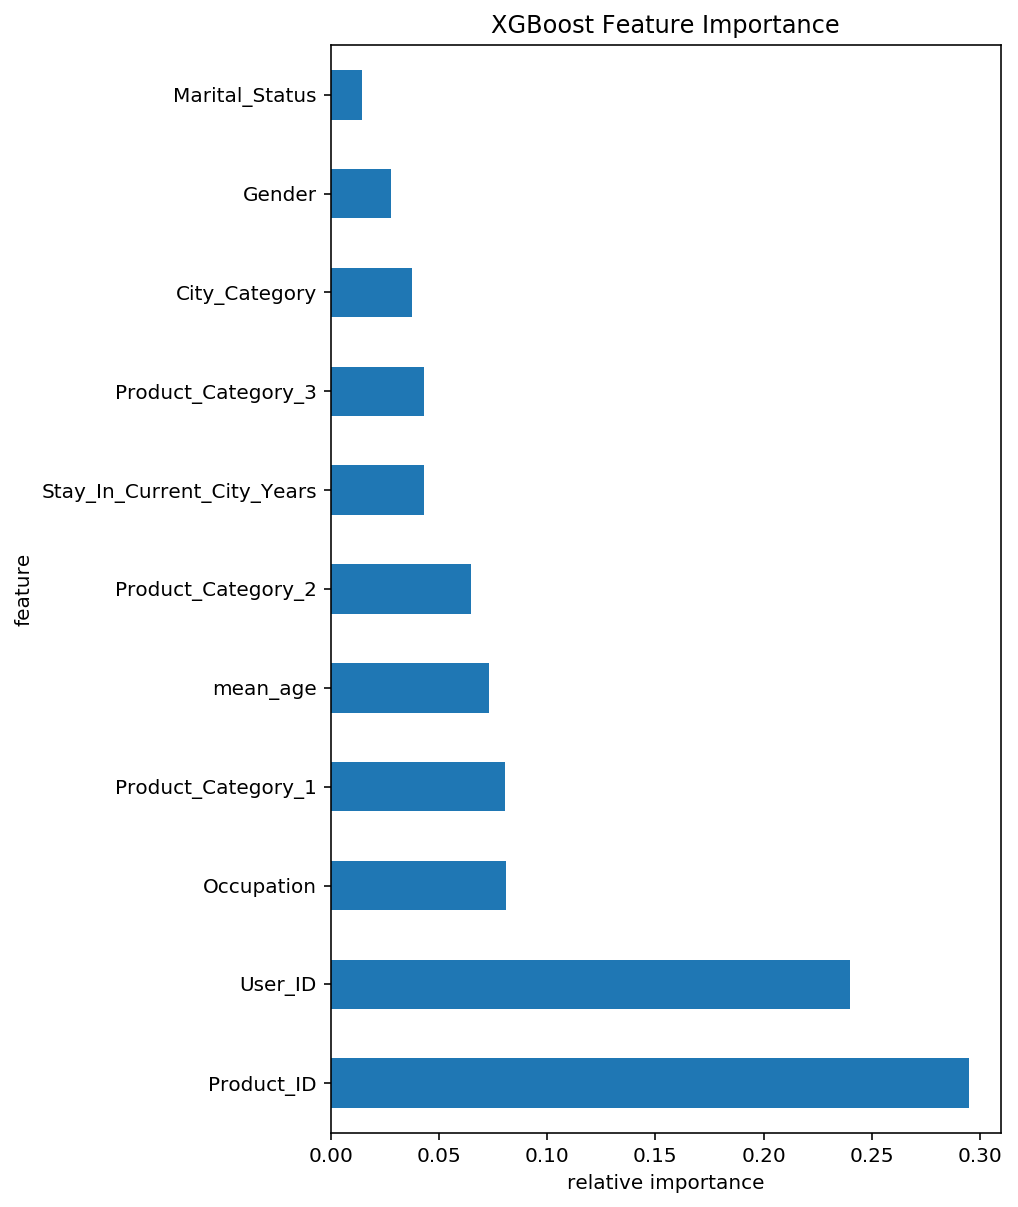

In [115]:
dtrain = pd.read_csv('data/cleaned_train.csv')
features = dtrain.iloc[:, 0:-1]
labels = dtrain.Purchase
xgb_feature_importance(features, labels, 1000)

## Variable importance with feature selection

[0]	train-rmse:10440.3
[1]	train-rmse:10343.9
[2]	train-rmse:10248.5
[3]	train-rmse:10154.2
[4]	train-rmse:10060.9
[5]	train-rmse:9968.6
[6]	train-rmse:9877.29
[7]	train-rmse:9786.97
[8]	train-rmse:9697.65
[9]	train-rmse:9609.29
[10]	train-rmse:9521.88
[11]	train-rmse:9435.43
[12]	train-rmse:9349.93
[13]	train-rmse:9265.36
[14]	train-rmse:9181.73
[15]	train-rmse:9099
[16]	train-rmse:9017.2
[17]	train-rmse:8936.29
[18]	train-rmse:8856.28
[19]	train-rmse:8777.14
[20]	train-rmse:8698.9
[21]	train-rmse:8621.53
[22]	train-rmse:8545
[23]	train-rmse:8469.33
[24]	train-rmse:8394.47
[25]	train-rmse:8320.47
[26]	train-rmse:8247.3
[27]	train-rmse:8174.93
[28]	train-rmse:8103.35
[29]	train-rmse:8032.61
[30]	train-rmse:7962.67
[31]	train-rmse:7893.47
[32]	train-rmse:7825.09
[33]	train-rmse:7757.47
[34]	train-rmse:7690.61
[35]	train-rmse:7624.51
[36]	train-rmse:7559.15
[37]	train-rmse:7494.51
[38]	train-rmse:7430.65
[39]	train-rmse:7367.5
[40]	train-rmse:7305.1
[41]	train-rmse:7243.36
[42]	train-rms

[335]	train-rmse:2796.98
[336]	train-rmse:2796.29
[337]	train-rmse:2795.53
[338]	train-rmse:2794.8
[339]	train-rmse:2794.03
[340]	train-rmse:2793.23
[341]	train-rmse:2792.56
[342]	train-rmse:2791.87
[343]	train-rmse:2791.22
[344]	train-rmse:2790.54
[345]	train-rmse:2789.77
[346]	train-rmse:2789.12
[347]	train-rmse:2788.5
[348]	train-rmse:2787.7
[349]	train-rmse:2786.74
[350]	train-rmse:2786.15
[351]	train-rmse:2785.49
[352]	train-rmse:2784.53
[353]	train-rmse:2783.97
[354]	train-rmse:2783.27
[355]	train-rmse:2782.68
[356]	train-rmse:2781.98
[357]	train-rmse:2781.43
[358]	train-rmse:2780.81
[359]	train-rmse:2780.2
[360]	train-rmse:2779.66
[361]	train-rmse:2778.9
[362]	train-rmse:2778.41
[363]	train-rmse:2777.75
[364]	train-rmse:2777.19
[365]	train-rmse:2776.68
[366]	train-rmse:2775.84
[367]	train-rmse:2775.13
[368]	train-rmse:2774.66
[369]	train-rmse:2773.84
[370]	train-rmse:2773.28
[371]	train-rmse:2772.74
[372]	train-rmse:2772.28
[373]	train-rmse:2771.85
[374]	train-rmse:2771.36
[375]

[664]	train-rmse:2678.16
[665]	train-rmse:2678
[666]	train-rmse:2677.84
[667]	train-rmse:2677.76
[668]	train-rmse:2677.64
[669]	train-rmse:2677.47
[670]	train-rmse:2677.33
[671]	train-rmse:2677.08
[672]	train-rmse:2676.77
[673]	train-rmse:2676.68
[674]	train-rmse:2676.51
[675]	train-rmse:2676.35
[676]	train-rmse:2676.22
[677]	train-rmse:2676.06
[678]	train-rmse:2675.75
[679]	train-rmse:2675.62
[680]	train-rmse:2675.47
[681]	train-rmse:2675.3
[682]	train-rmse:2675.24
[683]	train-rmse:2675.11
[684]	train-rmse:2674.9
[685]	train-rmse:2674.72
[686]	train-rmse:2674.4
[687]	train-rmse:2674.1
[688]	train-rmse:2673.95
[689]	train-rmse:2673.87
[690]	train-rmse:2673.76
[691]	train-rmse:2673.6
[692]	train-rmse:2673.46
[693]	train-rmse:2673.29
[694]	train-rmse:2673.2
[695]	train-rmse:2672.91
[696]	train-rmse:2672.73
[697]	train-rmse:2672.6
[698]	train-rmse:2672.45
[699]	train-rmse:2672.29
[700]	train-rmse:2672.2
[701]	train-rmse:2671.89
[702]	train-rmse:2671.69
[703]	train-rmse:2671.54
[704]	train

[994]	train-rmse:2630.49
[995]	train-rmse:2630.3
[996]	train-rmse:2630.15
[997]	train-rmse:2629.96
[998]	train-rmse:2629.85
[999]	train-rmse:2629.75


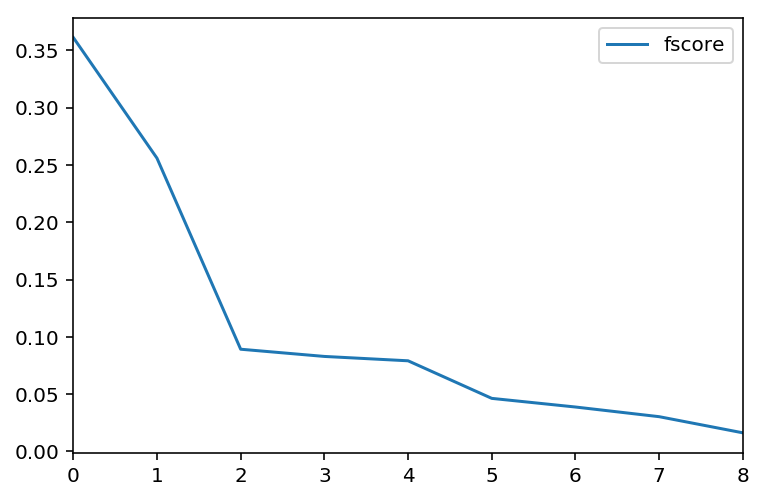

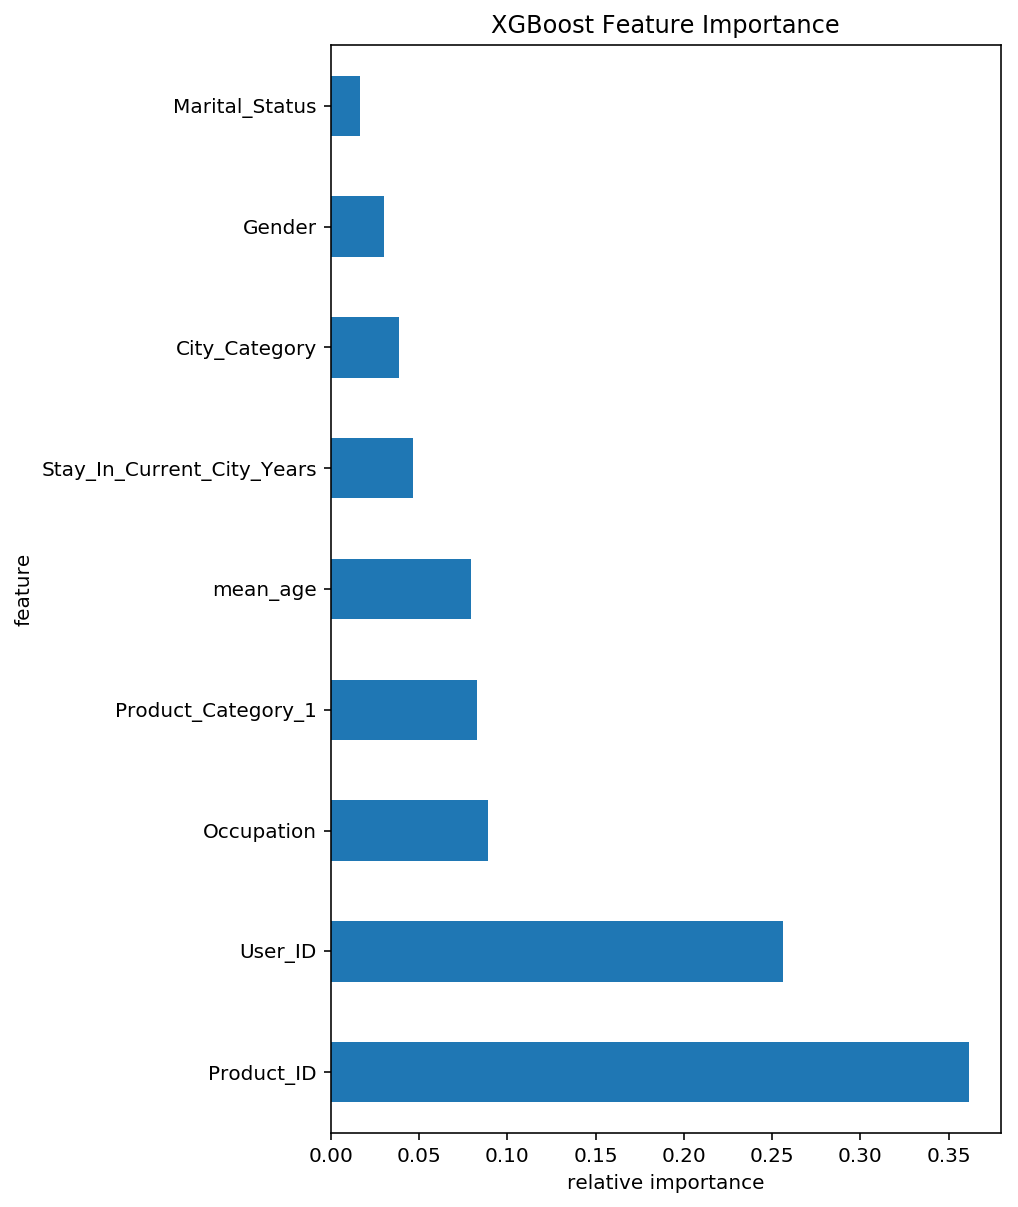

In [149]:
cols = [
    'User_ID',
    'Product_ID',
    'Gender',
    'Occupation',
    'City_Category',
    'Stay_In_Current_City_Years',
    'Marital_Status',
    'Product_Category_1',
    'mean_age',
    'Purchase'
]
train = cleaned_train[cols]

features = train.iloc[:, 0:-1]
labels = train.Purchase
xgb_feature_importance(features, labels, 1000)